In [2]:
from src.makedata import *
from src.makemodel import *
from src.reconst import *

In [3]:
isTrain = False  # set model in testing mode
isContinue = False
savedir = "./log/"
loadpath = "UNet_nonscl_pre387*.pth"  # load model weights

In [4]:
model = GlomNet(isTrain, isContinue, savedir, loadpath, "UNet")

_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)
[CREATE] MODEL


Downloading: "https://download.pytorch.org/models/vgg13_bn-abd245e5.pth" to /root/.cache/torch/checkpoints/vgg13_bn-abd245e5.pth



UNet
UNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(12

O27
slide size (1439, 3859, 3)
slide size after padding (1536, 4096, 3)
collected patches size (96, 320, 320, 3)
#glom on GT =  60 
#glom on Prediction =  55


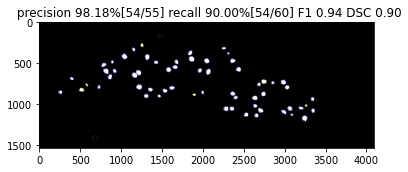

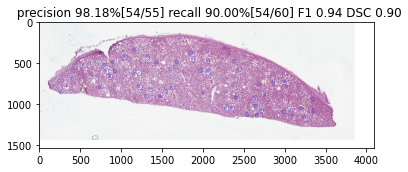

In [7]:
# window-slide and centor crop setting  
patchsize = 256 # center area size
padding = 64 # boundary that need to be excluded when stitch together

# for reconstruction, input is a whole slide image
inds = os.listdir("./data/WSI")

for name in inds[:]:
    (typ,idi) = name.split('.')[0].split('_')
    if(typ=='mask'):
      continue
    print(idi)

    # read slide image for reconstruction and GT mask for comparasion
    img_dir = 'slide_{}.png'.format(idi)
    msk_dir = img_dir.replace('slide','mask')
    img = np.array(Image.open("./data/WSI/{}".format(img_dir)))
    msk = cv2.imread("./data/WSI/{}".format(msk_dir))/255
    print("slide size", img.shape)

    # pad to a suitable size for window-slide patch extraction
    msk = pad_msk(msk,patchsize)[:,:,0]
    img,rr,cc = pad_img(img,patchsize)
    # extract all patches from the whole slide with calculated rows and columns
    io_arr_out = np.array(ext(img,rr,cc,patchsize,padding))
    io_arr_out = io_arr_out.reshape(-1,patchsize+padding,patchsize+padding,3)
    print("slide size after padding", img.shape)
    print("collected patches size",io_arr_out.shape)
    
    # convert patches into tensor format and add skip flag to 
    # patches on white backgrounds for computation saving
    inputs, skip = to_tensor(io_arr_out)
    results = get_results(model, inputs, skip)
    
    # reconstruct whole slide prediction by stitching output results
    newmask = np.zeros((msk.shape[0], msk.shape[1]), dtype=bool)
    new_mask = reconst_mask(newmask,results,rr,cc,patchsize,padding)
    new_mask = new_mask.astype('bool')
    # compute dice score for whole slide segmentation performance
    score = dice(msk[:,:],new_mask)
    
    #-------start comparation with GT mask---------
    # find all glomeruli contours 
    contours_y = measure.find_contours(msk, 0.8)
    contours_p = measure.find_contours(new_mask, 0.8)
    
    # turn each glom into a mask
    shape = msk.shape
    mask_y = get_masks(contours_y,shape)
    mask_p = get_masks(contours_p,shape)
    contours_y,mask_y = rm_small(contours_y,mask_y)
    contours_p,mask_p = rm_small(contours_p,mask_p)
    cnty,cntp=len(contours_y),len(contours_p)
    print("#glom on GT = ",cnty,"\n#glom on Prediction = ",cntp)
    
    # check prediction gloms with GT gloms one by one 
    flag_p,flag_y = make_compare(mask_y,mask_p,contours_p,contours_y)
    # plot compararion results on GT mask, blue contours are TP, green are FP, yellow are FN 
    precise, cntp, recall, find, tol, f1, dsc = save_plot(flag_p,flag_y,contours_p,contours_y,score, msk, idi, "mask", cc, rr, patchsize)
    precise, cntp, recall, find, tol, f1, dsc = save_plot(flag_p,flag_y,contours_p,contours_y,score, img, idi, "slide", cc, rr, patchsize)